In [49]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Input, UpSampling2D, Reshape, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [50]:
# Load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize images to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [51]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [52]:
def build_generator():
    model = Sequential()

    # Initial fully connected layer
    model.add(Dense(256 * 8 * 8, activation="relu", input_dim=100))
    model.add(Reshape((8, 8, 256)))

    # Upsampling and convolution layers
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # Final convolutional layer for color channels
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

    return model


In [53]:
def build_discriminator():
    model = Sequential()

    # Convolutional layers with strides for downsampling
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(32, 32, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # Flatten and classify
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


In [54]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    img = generator(gan_input)
    gan_output = discriminator(img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

gan = build_gan(generator, discriminator)
gan.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         2544899   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 95297     
                                                                 
Total params: 2640196 (10.07 MB)
Trainable params: 2544131 (9.71 MB)
Non-trainable params: 96065 (375.25 KB)
_________________________________________________________________


In [55]:
def train_gan(generator, discriminator, gan, epochs, batch_size):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print the progress
        print(f"{epoch + 1} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")

# Set hyperparameters
epochs = 10000
batch_size = 64

# Train the GAN model
train_gan(generator, discriminator, gan, epochs, batch_size)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
7501 [D loss: 0.6938733756542206, acc.: 51.5625%] [G loss: 0.6974983811378479]
1/1 [==============================] - 0s 23ms/step
7502 [D loss: 0.6938960552215576, acc.: 40.625%] [G loss: 0.6967096328735352]
1/1 [==============================] - 0s 18ms/step
7503 [D loss: 0.6930107772350311, acc.: 46.875%] [G loss: 0.696820855140686]
1/1 [==============================] - 0s 26ms/step
7504 [D loss: 0.6930556893348694, acc.: 48.4375%] [G loss: 0.6969093084335327]
1/1 [==============================] - 0s 20ms/step
7505 [D loss: 0.6931559443473816, acc.: 50.0%] [G loss: 0.6976237297058105]
1/1 [==============================] - 0s 22ms/step
7506 [D loss: 0.6934679448604584, acc.: 51.5625%] [G loss: 0.697642982006073]
1/1 [==============================] - 0s 16ms/step
7507 [D loss: 0.6934309005737305, acc.: 50.0%] [G loss: 0.6962246894836426]
1/1 [==============================] - 0s 

In [56]:
# Evaluate the discriminator on test data
test_loss_real, test_acc_real = discriminator.evaluate(X_test, np.ones((X_test.shape[0], 1)))
print(f'Real Test Accuracy: {test_acc_real * 100}%')

# Generate fake images using the generator
noise = np.random.normal(0, 1, (X_test.shape[0], 100))
gen_imgs = generator.predict(noise)

# Evaluate the discriminator on generated (fake) images
test_loss_fake, test_acc_fake = discriminator.evaluate(gen_imgs, np.zeros((X_test.shape[0], 1)))
print(f'Fake Test Accuracy: {test_acc_fake * 100}%')


313/313 [==============================] - 1s 2ms/step - loss: 0.6919 - accuracy: 0.6459
Real Test Accuracy: 64.5900011062622%
313/313 [==============================] - 1s 2ms/step - loss: 0.6943 - accuracy: 0.4740
Fake Test Accuracy: 47.40000069141388%


In [57]:
# Convert color images to grayscale
def convert_to_grayscale(images):
    grayscale_images = np.zeros((images.shape[0], images.shape[1], images.shape[2]), dtype=np.uint8)
    for i in range(images.shape[0]):
        grayscale_images[i] = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
    grayscale_images = np.expand_dims(grayscale_images, axis=-1)  # Add channel dimension
    return grayscale_images

# Convert a subset of training images to grayscale
num_images = 10  # Number of images to display
grayscale_images = convert_to_grayscale(X_train[:num_images])

# Ensure the grayscale images are normalized to the range [0, 1]
grayscale_images = grayscale_images.astype('float32') / 255.0

# Generate random noise as input for the generator
noise = np.random.normal(0, 1, (num_images, 100))

# Use the generator to create colorized images from grayscale images
colorized_images = generator.predict(noise)


1/1 [==============================] - 0s 18ms/step


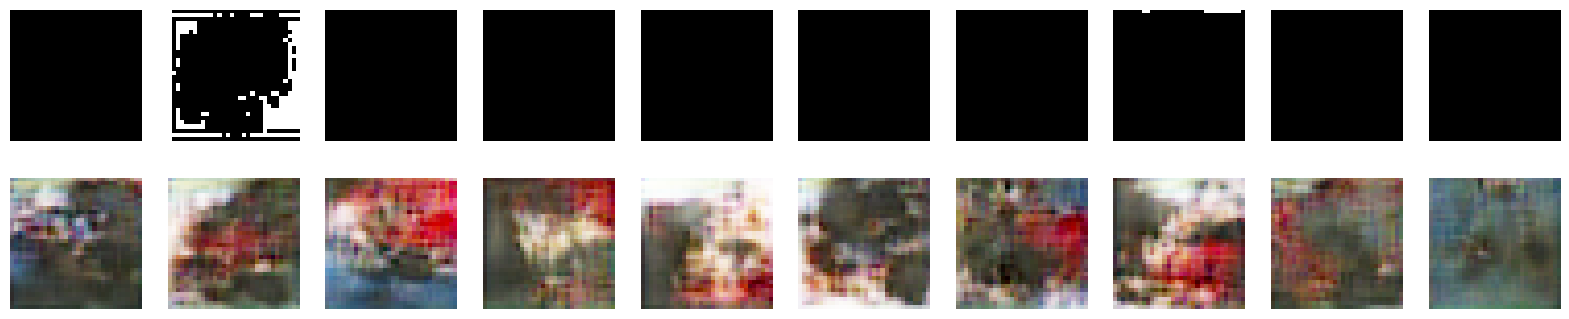

In [58]:
# Function to display images
def display_images(original, colorized, num_images):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display original grayscale image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Display colorized image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(colorized[i])
        plt.axis('off')

# Display the images
display_images(grayscale_images, colorized_images, num_images)
plt.show()


In [59]:
import cv2
import numpy as np

def post_process(image):
    # Convert image to uint8
    image = (image * 255).astype(np.uint8)

    # Adjust contrast (optional)
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=0)

    # Denoise (optional)
    image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

    # Convert back to float32 and normalize to [0, 1]
    image = image.astype(np.float32) / 255.0

    return image


In [60]:
# Generate colorized images
colorized_images = generator.predict(noise)

# Apply post-processing to enhance clarity
processed_colorized_images = np.zeros_like(colorized_images)
for i in range(num_images):
    processed_colorized_images[i] = post_process(colorized_images[i])





1/1 [==============================] - 0s 21ms/step


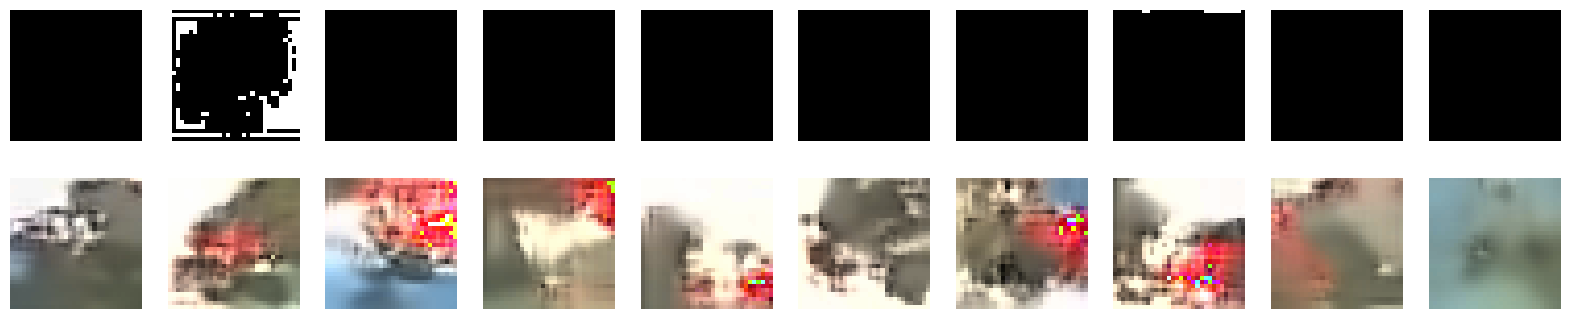

In [61]:
display_images(grayscale_images, processed_colorized_images, num_images)
plt.show()
